# Product Sales Forecasting — Scenario-Based Planning Analysis

A decision-focused forecasting project designed to support inventory and capacity planning under demand uncertainty.

# Business Context & Planning Objective

This analysis supports **quarter-ahead inventory and capacity planning** for a multi-region retail business.

Leadership decisions supported:
- How much inventory to stock for the next planning cycle
- Which demand scenarios pose operational or financial risk
- How sensitive planning decisions are to demand volatility

This project prioritizes **decision confidence over forecast precision**.
Forecast outputs are treated as **inputs to planning**, not final answers.

# Setup & Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


# Load Data

In [2]:
train = pd.read_csv("TRAIN.csv")
test = pd.read_csv("TEST_FINAL.csv")

# Preview
print(train.shape)
train.head()

(188340, 10)


,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52


# Data Cleaning & Feature Engineering

In [3]:
# Convert Date
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [4]:
# Basic Checks
train.isna().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

In [5]:
# If missing values exist, handle them
train = train.dropna()

In [6]:
# Convert Discount to Binary
train['Discount'] = train['Discount'].map({'Yes': 1, 'No': 0})
test['Discount'] = test['Discount'].map({'Yes': 1, 'No': 0})

In [7]:
# Time Features
for df in [train, test]:
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfWeek'] = df['Date'].dt.dayofweek


# Assumptions & Planning Constraints

The following assumptions materially impact forecast interpretation:

1. **Historical Continuity**
   - Assumes no structural break in customer behavior
   - Risk: Forecast may understate demand shocks or regime changes

2. **Seasonality Stability**
   - Assumes recurring demand patterns persist
   - Risk: Seasonal shifts could misalign inventory timing

3. **Excluded External Factors**
   - Marketing campaigns, competitor actions, macroeconomic shifts not modeled
   - Risk: Forecasts should not be used for long-term financial commitments

These assumptions mean forecasts are **directional planning tools**, not guarantees.


# EDA — Decision-Driven

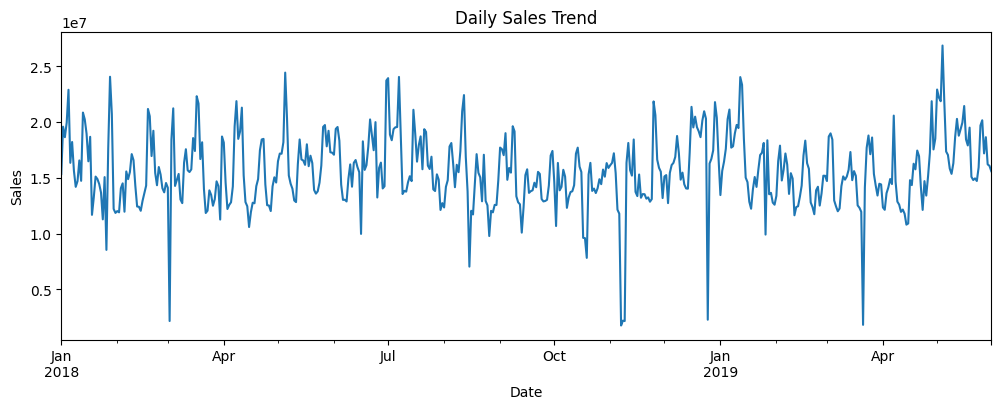

In [8]:
# A. Sales Trend Over Time
daily_sales = train.groupby('Date')['Sales'].sum()

plt.figure(figsize=(12,4))
daily_sales.plot()
plt.title("Daily Sales Trend")
plt.ylabel("Sales")
plt.show()

### Time Trend / Seasonality — Decision Implication
- Demand varies meaningfully over time and should not be planned uniformly.
- Use rolling forecasts and seasonal adjustments instead of static inventory targets.

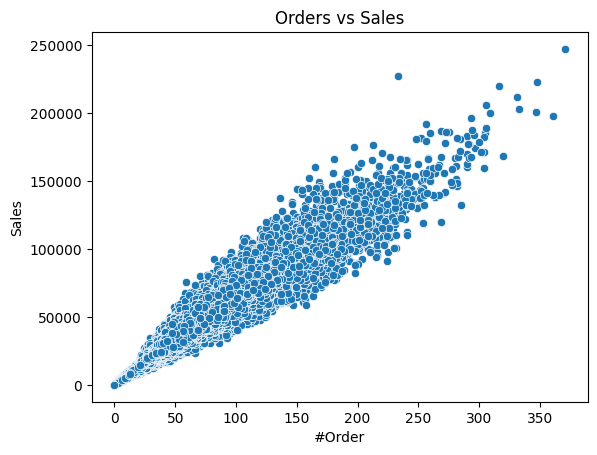

,#Order,Sales
#Order,1.000000,0.941601
Sales,0.941601,1.000000


In [9]:
# B. Orders vs Sales
sns.scatterplot(data=train, x='#Order', y='Sales')
plt.title("Orders vs Sales")
plt.show()

train[['#Order', 'Sales']].corr()

### Orders vs Sales — Decision Implication
- Sales scale directly with order volume, making availability a primary revenue constraint.
- Ensure inventory and fulfillment capacity are aligned with expected order spikes.

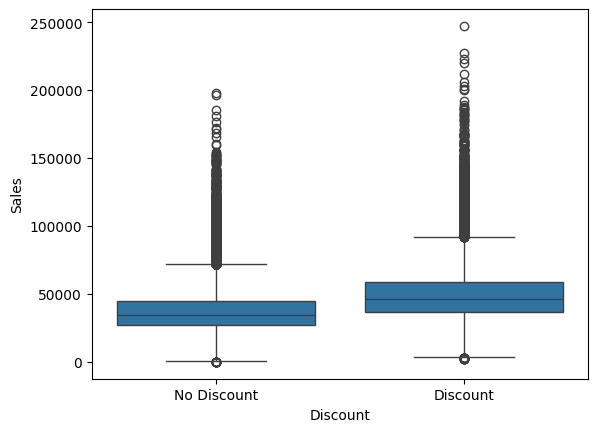

In [10]:
# C. Discount Impact (T-Test)
sales_discount = train[train['Discount'] == 1]['Sales']
sales_no_discount = train[train['Discount'] == 0]['Sales']

stats.ttest_ind(sales_discount, sales_no_discount, equal_var=False)

sns.boxplot(data=train, x='Discount', y='Sales')
plt.xticks([0,1], ['No Discount','Discount'])
plt.show()

### Discount Impact — Decision Implication
- Treat discount-driven demand as temporary uplift, not baseline growth.
- Plan additional buffers for promotions while avoiding long-term inventory commitments based on discounted sales.

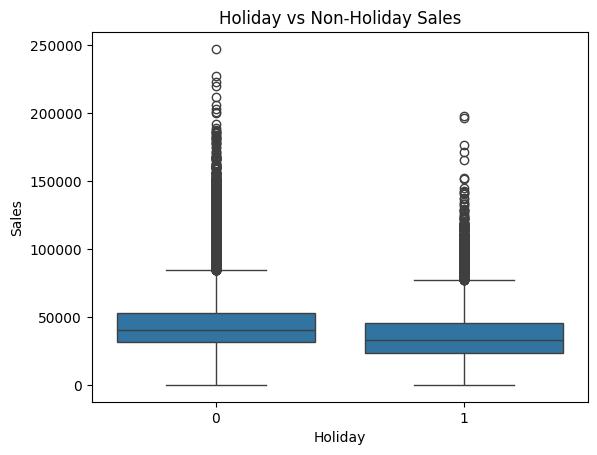

In [11]:
# D. Holiday Impact
sns.boxplot(data=train, x='Holiday', y='Sales')
plt.title("Holiday vs Non-Holiday Sales")
plt.show()

### Holiday Impact — Decision Implication
- Holiday demand is predictable and should be planned proactively.
- Pre-position inventory ahead of known peak periods to avoid reactive replenishment.

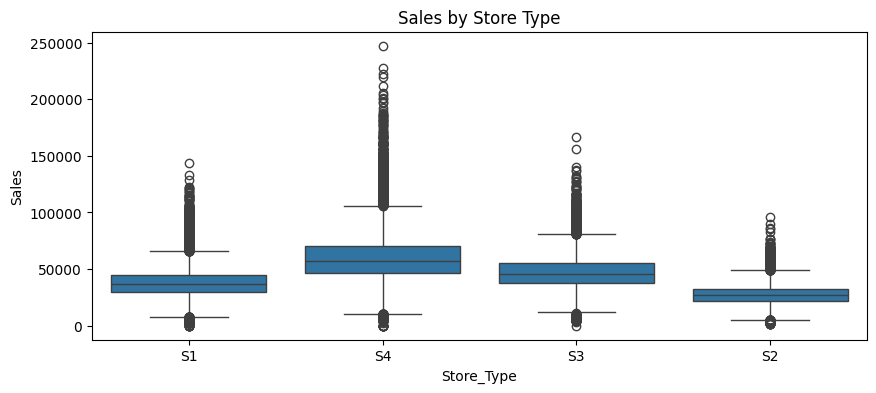

In [12]:
# E. Store Type 
plt.figure(figsize=(10,4))
sns.boxplot(data=train, x='Store_Type', y='Sales')
plt.title("Sales by Store Type")
plt.show()

### Store Type — Decision Implication
- Concentrate inventory and assortment depth in high-performing store types.
- Avoid uniform stocking across store formats; underperforming types require demand validation before scaling supply.

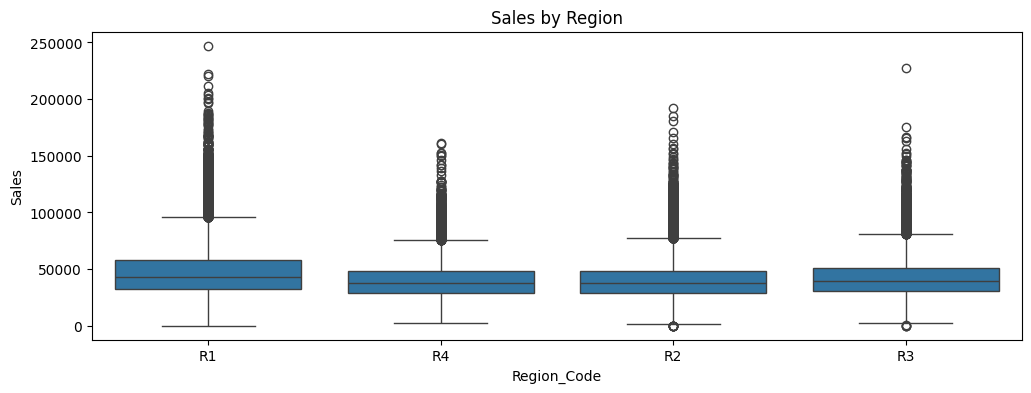

In [13]:
# F. Region Variability
plt.figure(figsize=(12,4))
sns.boxplot(data=train, x='Region_Code', y='Sales')
plt.title("Sales by Region")
plt.show()

### Region — Decision Implication
- Allocate higher safety stock to consistently high-demand regions.
- Apply conservative inventory policies in volatile or low-demand regions to reduce overstock risk.

# Aggregate for Forecasting

In [14]:
# For planning, aggregate daily sales.
forecast_df = train.groupby('Date')['Sales'].sum().reset_index()
forecast_df.head()

,Date,Sales
0,2018-01-01,15345484.5
1,2018-01-02,19592415.0
2,2018-01-03,18652527.0
3,2018-01-04,19956267.0
4,2018-01-05,22902651.0


# Baseline Forecast Model (Simple & Stable)
#### The baseline model is intentionally simple to prioritize interpretability and stability over marginal accuracy gains.

In [15]:
# Create Time Index
forecast_df['t'] = np.arange(len(forecast_df))

In [16]:
# Train Model
X = forecast_df[['t']]
y = forecast_df['Sales']

model = LinearRegression()
model.fit(X, y)

forecast_df['Base_Forecast'] = model.predict(X)

# Forecast Horizon (Next 30 Days)

In [17]:
future_days = 30
last_t = forecast_df['t'].max()

future_df = pd.DataFrame({
    't': np.arange(last_t + 1, last_t + future_days + 1)
})

future_df['Base_Forecast'] = model.predict(future_df[['t']])

# Scenario Construction (THIS IS THE KEY PART)

In [18]:
future_df['Optimistic_Forecast'] = future_df['Base_Forecast'] * 1.10
future_df['Conservative_Forecast'] = future_df['Base_Forecast'] * 0.90

### Why Scenario-Based Forecasting (Instead of a Single Prediction)

Single-point forecasts create false confidence in uncertain environments.
This analysis intentionally models **multiple demand outcomes** to answer:

- What if demand underperforms expectations?
- What if demand exceeds historical trends?
- Which decisions remain valid across scenarios?

Scenarios allow leadership to stress-test inventory, staffing, and cash flow decisions
*before* uncertainty materializes.

# Scenario Visualization

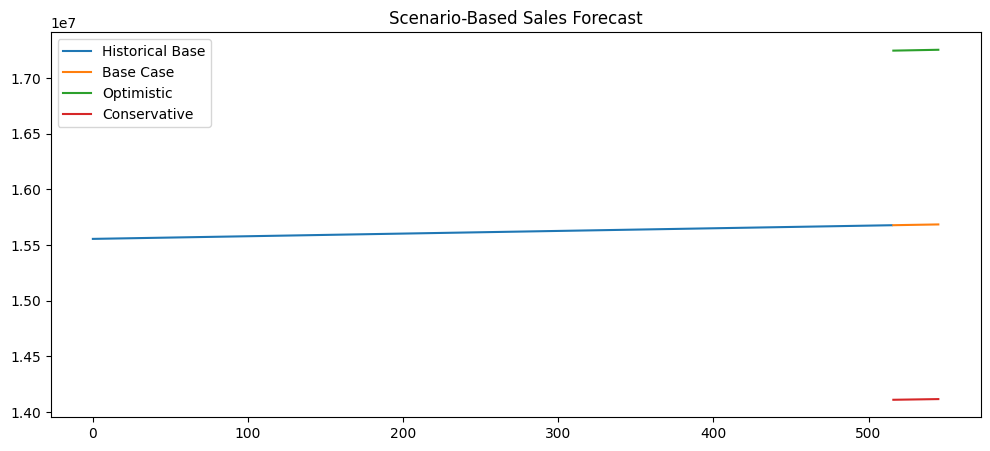

In [19]:
plt.figure(figsize=(12,5))

plt.plot(forecast_df['Base_Forecast'], label='Historical Base')
plt.plot(
    range(len(forecast_df), len(forecast_df) + future_days),
    future_df['Base_Forecast'], label='Base Case'
)

plt.plot(
    range(len(forecast_df), len(forecast_df) + future_days),
    future_df['Optimistic_Forecast'], label='Optimistic'
)

plt.plot(
    range(len(forecast_df), len(forecast_df) + future_days),
    future_df['Conservative_Forecast'], label='Conservative'
)

plt.legend()
plt.title("Scenario-Based Sales Forecast")
plt.show()

# Translate Forecast → Action (Planning Table)

In [20]:
summary = pd.DataFrame({
    'Scenario': ['Base', 'Optimistic', 'Conservative'],
    'Expected_Avg_Sales': [
        future_df['Base_Forecast'].mean(),
        future_df['Optimistic_Forecast'].mean(),
        future_df['Conservative_Forecast'].mean()
    ]
})

summary

,Scenario,Expected_Avg_Sales
0,Base,1.568130e+07
1,Optimistic,1.724943e+07
2,Conservative,1.411317e+07


## Scenario-Based Planning Actions

| Scenario        | Demand Signal | Recommended Action |
|-----------------|---------------|--------------------|
| Optimistic      | Sustained uplift | Increase inventory buffers, ensure supplier readiness |
| Base Case       | Stable demand | Maintain current stocking levels with minor safety stock |
| Conservative    | Demand softening | Reduce procurement risk, delay discretionary purchases |


# Save Outputs for Power BI

In [21]:
forecast_output = future_df.copy()
forecast_output.to_csv("forecast_scenarios.csv", index=False)

summary.to_csv("scenario_summary.csv", index=False)


# Appropriate Use of This Forecast

***This forecast should be used for:***
- Short-term inventory and resource planning
- Scenario stress-testing and contingency planning

***This forecast should NOT be used for:***
- Long-term revenue commitments
- Pricing strategy decisions without additional modeling
- Financial forecasting without confidence intervals

## Final Recommendation to Leadership

Given observed demand variability across regions and store types:

- Adopt **scenario-based inventory planning** instead of single-number forecasts
- Allocate conservative buffers to high-volatility regions
- Operate lean inventory in stable demand segments
- Re-evaluate forecasts monthly as new demand signals emerge

This approach minimizes downside risk while preserving upside readiness.

## Next Analytical Extensions

With additional time or data, this analysis could be extended to:
- Incorporate confidence intervals and probabilistic forecasts
- Model region-specific demand scenarios
- Integrate promotion calendars and external demand drivers

# Data Note

The dataset used in this project is assumed to be anonymized and representative.
Results are intended for analytical demonstration and planning logic illustration.